In [1]:
import dpkt
import os
import struct
import numpy as np
from collections import defaultdict
from pprint import pprint

try:
    from Memoizer import memoize_to_folder
    memoize = memoize_to_folder("e2e_memoization")
except:
    # In case Memoizer isn't present, this decorator will just do nothing
    print("Warning: Unable to import memoizer")
    memoize = lambda x : x


In [8]:
from scapy.all import *

K = 5
H = 1

def blk_cls_idx(fec,):
    blk_cls_idx, = struct.unpack("!H", fec[:2])
    blk = (blk_cls_idx >> 8) & 0b00011111
    cls = ((blk_cls_idx >> 8) & 0b11100000) >> 5
    idx = blk_cls_idx & 0x0F
    
    pkt_len, = struct.unpack("H", fec[4:6])
    return blk, cls, idx, pkt_len

@memoize
def get_latencies(out_dir,
                  encoded_input = False,
                  encoded_output = False,
                  dst_mac_is_ts = True, 
                  compare_counters = True,
                  expected_class = 0):
    
    pcf = os.path.join(out_dir, 'moongen', 'moongen.pcap')
    
    ts_in = []
    ts_out = []    

    f = open(pcf, 'rb')
    print("Reading {}".format(pcf))
    pcap=dpkt.pcap.Reader(f)
    
    last_blk_idx = [None, -1]
    block_buffer = []
    
    n_discarded_buffer = 0
    n_discarded_unknown = 0
    
    def handle_block_buffer(fec, ts, ts_buff):        
        nonlocal n_discarded_unknown, n_discarded_buffer, block_buffer, last_blk_idx
        
        blk, cls, idx, pkt_len = blk_cls_idx(fec)
#         print(blk,cls,idx)
        
        if (cls != expected_class):
            IP(fec).show()
            n_discarded_unknown += 1
            return

        if last_blk_idx[0] is not None and \
                last_blk_idx[0] != blk or \
                last_blk_idx[1] >= idx:
            print(last_blk_idx, blk, idx, K, block_buffer)
            if len(block_buffer) != K:
                raise Exception("Unfinished block with %d entries" % len(block_buffer))
            ts_buff.extend(block_buffer)
            block_buffer = []
 
        last_blk_idx[0] = blk
        last_blk_idx[1] = idx
        
        if len(block_buffer) >= K:
            n_discarded_buffer += 1
            return

        block_buffer.append(ts)  
        
    skipped = 0
    tss = []
    sort_ts_in = []
    sort_ts_out = []
    #Loop to sort encoded packets based on timestamp. At times the first packet was arriving \
    #out of order, so to prevent that issue, sorting is done.
    for i, (ts, buf) in enumerate(pcap):
        try:
            eth=dpkt.ethernet.Ethernet(buf)
            fec = eth.data

        except Exception as e:
            print("Exception parsing packet {} : {}".format(buf, e))
            Ether(buf).show2()
            raise

        if dst_mac_is_ts:
            x3, x2, x1 = struct.unpack("!HHH", eth.dst)
            ts = float((x3 << 32) | (x2 << 16) | x1) * 1e-9
            
        ### Assumes src mac is origin
        x3, x2, x1 = struct.unpack("!HHH", eth.src)
        
        if x1 == 1:                
            if encoded_output:    
                sort_ts_out.append([ts, fec])
            else:
                ts_out.append(ts)
        elif x1 == 2:
            if encoded_input:
                sort_ts_in.append([ts, fec])
            else:
                ts_in.append(ts)
    
    #block of code to sort by first item in the list
    def get_key(item):
        return item[0]
    
    if encoded_input:
        sort_ts_in = sorted(sort_ts_in, key=get_key)
    elif encoded_output:    
        sort_ts_out = sorted(sort_ts_out, key=get_key)
    
    
    if encoded_input:    
        for item in sort_ts_in:
            handle_block_buffer(item[1], item[0], ts_in)
    elif encoded_output:
        for item in sort_ts_out:
            handle_block_buffer(item[1], item[0], ts_out)
        
                
    print("Finished reading pcap: %d total packets \n"
          "Skipped %d packets due to broadcast UDP\n"
          "Discarded %d packets due to buffering \n" 
          "Discarded %d packets due to incorrect FEC class\n"
          "Got %d input and %d output packets"%
          (i, skipped, n_discarded_buffer, n_discarded_unknown, len(ts_in), len(ts_out)))
    
#     if len(block_buffer) != K and len(block_buffer) != 0:
#         raise Exception("Unfinished block at end with %d entries" % len(block_buffer))
        
    if encoded_input:
        ts_in.extend(block_buffer)
    elif encoded_output:
        ts_out.extend(block_buffer)
        
#     ts_in = ts_in[:len(ts_out)]
        
    if len(ts_in) != len(ts_out):
        raise Exception("Received %d input packets and %d output packets" %
                        (len(ts_in), len(ts_out)))
    
    print("Calculated %d latencies" % len(ts_out))
    
    return np.array(ts_in), np.array(ts_out) - np.array(ts_in)

In [21]:

EXP = '/home/ncshy/P4Boosters/testing/fec/execution/test_rerun/cpu_fec_decoder_rerun1/cpu_fec_decoder_rerun1_0.30'

#expected_class = 0 for FPGA; expected_class = 1 for CPU
#For encoded_input, pass encoded_input = True
#For encoded_output, pass encoded_output = True
latencies = get_latencies(EXP, encoded_input=True, expected_class=1)
tot = 0
count = 0
for val in latencies[1]:
    tot += val
    count += 1

#Code to calculate inter packet gap for input packets    
temp = 0
sub_count = 0
sub_tot = 0
for val in latencies[0]:
    if temp == 0:
        temp = val
        continue
    else:
        sub_tot += val - temp
        temp = val
    sub_count += 1    
    
sub_avg = sub_tot/sub_count    
avg = tot/count   
print((avg, tot, count))
print((sub_avg, sub_tot, sub_count))
print("Calculated avg latency %f" %(avg))

Reading /home/ncshy/P4Boosters/testing/fec/execution/test_rerun/cpu_fec_decoder_rerun1/cpu_fec_decoder_rerun1_0.30/moongen/moongen.pcap
[0, 5] 1 0 5 [26.789366702000002, 26.789401403000003, 26.789927176000003, 26.790211784, 26.790496306]
[1, 5] 2 0 5 [26.791065449, 26.791350010000002, 26.791634559000002, 26.791919206000003, 26.792203702000002]
[2, 5] 3 0 5 [26.792772868, 26.793057403000002, 26.793341906000002, 26.793401115, 26.793911071]
[3, 5] 4 0 5 [26.794480221, 26.794764825, 26.795049288, 26.795333906000003, 26.795618418]
[4, 5] 5 0 5 [26.796187607, 26.796472122, 26.796756743000003, 26.797041268, 26.797325797000003]
[5, 5] 0 0 5 [26.797894963, 26.798179511, 26.79846411, 26.798748655, 26.799033157]
[0, 5] 1 0 5 [26.799602297000003, 26.799886845000003, 26.800171472000002, 26.800456001, 26.800740536000003]
[1, 5] 2 0 5 [26.801309691, 26.801400753000003, 26.801878871000003, 26.802163377000003, 26.802447925000003]
[2, 5] 3 0 5 [26.803017054, 26.803301573000002, 26.803586207000002, 26.80

[3, 5] 4 0 5 [27.163766455, 27.164051086, 27.164335621000003, 27.16462015, 27.164904787]
[4, 5] 5 0 5 [27.165383356000003, 27.165758469, 27.16604307, 27.16632753, 27.166612144000002]
[5, 5] 0 0 5 [27.167181198, 27.167465822, 27.167750354000002, 27.168034879, 27.168319500000003]
[0, 5] 1 0 5 [27.168888686000003, 27.169173231000002, 27.169383181, 27.169742387000003, 27.170026899000003]
[1, 5] 2 0 5 [27.170596041000003, 27.170880576000002, 27.171165124, 27.171449752, 27.17173427]
[2, 5] 3 0 5 [27.172303424000003, 27.172587956, 27.172872544, 27.173157112000002, 27.173383001]
[3, 5] 4 0 5 [27.174010813000002, 27.174295315000002, 27.174579867000002, 27.174864491, 27.175149032]
[4, 5] 5 0 5 [27.175718173, 27.176002698, 27.176287315000003, 27.176571847, 27.176856376]
[5, 5] 0 0 5 [27.177382832000003, 27.177710074, 27.177994707000003, 27.178279256000003, 27.178563771]
[0, 5] 1 0 5 [27.179132918, 27.179417463, 27.179702090000003, 27.179986609, 27.180271177]
[1, 5] 2 0 5 [27.180840277, 27.1811248

[5, 5] 0 0 5 [27.556782007000002, 27.557066535, 27.557351054, 27.557364594000003, 27.557920210000002]
[0, 5] 1 0 5 [27.558489394000002, 27.558773923, 27.559058555, 27.559343077, 27.559627615]
[1, 5] 2 0 5 [27.560196768, 27.560481290000002, 27.560765914, 27.561050446000003, 27.561334958000003]
[2, 5] 3 0 5 [27.561904186000003, 27.562188665, 27.562473290000003, 27.562757819, 27.563042364]
[3, 5] 4 0 5 [27.563611530000003, 27.563896094, 27.564180689, 27.564465244, 27.564749756]
[4, 5] 5 0 5 [27.565318889, 27.565364235, 27.565888065000003, 27.566172578000003, 27.566457182]
[5, 5] 0 0 5 [27.567026262000002, 27.567310912, 27.567595428, 27.567879963000003, 27.568164600000003]
[0, 5] 1 0 5 [27.568733677, 27.569018299000003, 27.569302827, 27.56936406, 27.569871996000003]
[1, 5] 2 0 5 [27.570441037000002, 27.570725664, 27.571010200000003, 27.571294715, 27.571579362]
[2, 5] 3 0 5 [27.572148419, 27.572433080000003, 27.572717606, 27.573002226000003, 27.573286761000002]
[3, 5] 4 0 5 [27.573855901, 2

[4, 5] 5 0 5 [27.934517760000002, 27.934802285000004, 27.935086814, 27.935371602, 27.935655967000002]
[5, 5] 0 0 5 [27.936225114000003, 27.936509642, 27.936794174000003, 27.937078821, 27.937346453]
[0, 5] 1 0 5 [27.937932528, 27.938217050000002, 27.938501579, 27.938786203000003, 27.939070722]
[1, 5] 2 0 5 [27.939639895000003, 27.939924444000003, 27.940209064, 27.940493596000003, 27.940778115]
[2, 5] 3 0 5 [27.941346254000003, 27.941633455, 27.941918069000003, 27.942202617000003, 27.942487146]
[3, 5] 4 0 5 [27.943056303000002, 27.943340838, 27.943625465, 27.943909981, 27.944194536]
[4, 5] 5 0 5 [27.944763668, 27.945048200000002, 27.945332808000003, 27.945346098, 27.945901872]
[5, 5] 0 0 5 [27.946471044000003, 27.946755681000003, 27.94704038, 27.947324751, 27.947609382000003]
[0, 5] 1 0 5 [27.948178433000002, 27.948463073000003, 27.948747608, 27.949032130000003, 27.949316749]
[1, 5] 2 0 5 [27.949885809, 27.950170423000003, 27.950454962000002, 27.950739494, 27.951024104000002]
[2, 5] 3 0 

[2, 5] 3 0 5 [28.330840783000003, 28.331125299000004, 28.331409939, 28.331694465, 28.331978983000003]
[3, 5] 4 0 5 [28.332548166000002, 28.332832796, 28.333117308000002, 28.333327508, 28.333692434000003]
[4, 5] 5 0 5 [28.334261485000003, 28.334546108, 28.334830637000003, 28.335115186000003, 28.335399806]
[5, 5] 0 0 5 [28.335968873000002, 28.336253495, 28.336538034, 28.336822556, 28.337107183]
[0, 5] 1 0 5 [28.337676263000002, 28.337960887, 28.338245396, 28.338529938, 28.338814558000003]
[1, 5] 2 0 5 [28.339383725, 28.339479259, 28.339952782, 28.340237390000002, 28.340521951000003]
[2, 5] 3 0 5 [28.341091100000003, 28.341327136, 28.341660161, 28.341944788000003, 28.342229304000004]
[3, 5] 4 0 5 [28.342798461, 28.343082980000002, 28.343367508, 28.343652142000003, 28.343936677000002]
[4, 5] 5 0 5 [28.344505862000002, 28.344790381000003, 28.345074913, 28.345326967000002, 28.345644092]
[5, 5] 0 0 5 [28.346213252000002, 28.346497784, 28.346782414000003, 28.347066927, 28.347351462000002]
[0, 

[2, 5] 3 0 5 [28.710090758000003, 28.71037529, 28.710659809000003, 28.710944436000002, 28.711229004000003]
[3, 5] 4 0 5 [28.711798127, 28.712082688000002, 28.712367286000003, 28.712651919000002, 28.712936369]
[4, 5] 5 0 5 [28.713309362, 28.713790088000003, 28.714074702, 28.71435924, 28.714643779000003]
[5, 5] 0 0 5 [28.715212921000003, 28.715497447, 28.715782074000003, 28.716066606000002, 28.716351135]
[0, 5] 1 0 5 [28.716920285, 28.717204824000003, 28.717309163000003, 28.717773982, 28.718058518000003]
[1, 5] 2 0 5 [28.718627683, 28.718912311, 28.719196839000002, 28.719480411000003, 28.719541745]
[2, 5] 3 0 5 [28.720345243, 28.720629868000003, 28.720914407000002, 28.721198916000002, 28.721308904]
[3, 5] 4 0 5 [28.722052607000002, 28.722337215000003, 28.722621750000002, 28.722906302000002, 28.723190917]
[4, 5] 5 0 5 [28.723759987, 28.724044634000002, 28.724329156000003, 28.724613675, 28.724898295000003]
[5, 5] 0 0 5 [28.725308731000002, 28.725751983000002, 28.726036499000003, 28.7263211

[1, 5] 2 0 5 [29.097952810000002, 29.098237368000003, 29.098521972, 29.098806511000003, 29.099091059000003]
[2, 5] 3 0 5 [29.099660202000003, 29.099944757000003, 29.100229379, 29.100513904000003, 29.100798423]
[3, 5] 4 0 5 [29.101266947000003, 29.101652137000002, 29.101936718, 29.102221266, 29.102505867]
[4, 5] 5 0 5 [29.103074951000004, 29.103359543000003, 29.103644111, 29.103928636000003, 29.104213253]
[5, 5] 0 0 5 [29.104782327000002, 29.105066925000003, 29.105290601, 29.105363315, 29.105920619000003]
[0, 5] 1 0 5 [29.106489677000003, 29.106774298, 29.107058824000003, 29.107343349, 29.107627988]
[1, 5] 2 0 5 [29.108197052, 29.108481666000003, 29.108766198, 29.109050822, 29.109290395000002]
[2, 5] 3 0 5 [29.109904508000003, 29.110189033, 29.110473575, 29.110756504, 29.111065846000002]
[3, 5] 4 0 5 [29.111894337000003, 29.112178888000003, 29.112463506, 29.112748057, 29.113032573]
[4, 5] 5 0 5 [29.113601733000003, 29.113886232000002, 29.114170875000003, 29.114455404, 29.114739926000002

[2, 5] 3 0 5 [29.366435984000002, 29.366720512, 29.367005048000003, 29.367289662, 29.367574190000003]
[3, 5] 4 0 5 [29.36814335, 29.368427891000003, 29.368712400000003, 29.368997032000003, 29.369277948]
[4, 5] 5 0 5 [29.369850719000002, 29.370135251, 29.370419806, 29.370704411000002, 29.370988943]
[5, 5] 0 0 5 [29.371558102, 29.371842630000003, 29.372127153, 29.372411786, 29.372696322000003]
[0, 5] 1 0 5 [29.373265461000003, 29.373277794000003, 29.373834600000002, 29.374119135, 29.374403664000003]
[1, 5] 2 0 5 [29.374972807000002, 29.375257355000002, 29.37554198, 29.375826512000003, 29.37611107]
[2, 5] 3 0 5 [29.376680213, 29.376964735, 29.377249352000003, 29.377277589000002, 29.377818436000002]
[3, 5] 4 0 5 [29.378387579, 29.378672081, 29.378956732000002, 29.379241261, 29.379525809]
[4, 5] 5 0 5 [29.380094962, 29.380379595, 29.380664124000003, 29.380948640000003, 29.381233391000002]
[5, 5] 0 0 5 [29.381802328000003, 29.382086952, 29.382371484, 29.38265601, 29.382940627000004]
[0, 5] 1

[0, 5] 1 0 5 [29.752522193, 29.752806735000004, 29.75309125, 29.753259559000004, 29.753660419000003]
[1, 5] 2 0 5 [29.754229575, 29.754514110000002, 29.754798642, 29.755083266000003, 29.755367801000002]
[2, 5] 3 0 5 [29.755936975, 29.756221503000003, 29.756506012000003, 29.756790633, 29.757075191000002]
[3, 5] 4 0 5 [29.757644317, 29.757928843000002, 29.758213381, 29.758498038000003, 29.758782537000002]
[4, 5] 5 0 5 [29.759351703, 29.759636241000003, 29.759920878000003, 29.760205394000003, 29.760489942000003]
[5, 5] 0 0 5 [29.761059072000002, 29.761259187, 29.761628237000004, 29.761912759, 29.762197291000003]
[0, 5] 1 0 5 [29.762766445, 29.763050990000004, 29.763335617000003, 29.763620133000003, 29.763904668000002]
[1, 5] 2 0 5 [29.764473824000003, 29.764758385, 29.76504298, 29.765259004, 29.76561214]
[2, 5] 3 0 5 [29.766181204000002, 29.766465811000003, 29.766750346000002, 29.767034908000003, 29.767319509000004]
[3, 5] 4 0 5 [29.767888576, 29.768173213, 29.768457748000003, 29.76874229

[1, 5] 2 0 5 [30.153969474, 30.154254081, 30.154538617000004, 30.154823145, 30.155107874000002]
[2, 5] 3 0 5 [30.155676850000003, 30.155961468, 30.156246023, 30.156530538000002, 30.156815192000003]
[3, 5] 4 0 5 [30.157240219000002, 30.157668879000003, 30.157953408, 30.158238048, 30.158522570000002]
[4, 5] 5 0 5 [30.159091724000003, 30.15937624, 30.159660762, 30.159945395, 30.160229904]
[5, 5] 0 0 5 [30.16079908, 30.161083622000003, 30.161240079000002, 30.161652827, 30.161937424]
[0, 5] 1 0 5 [30.162506463000003, 30.162791028, 30.163075527, 30.163360154000003, 30.163644670000004]
[1, 5] 2 0 5 [30.164213844000002, 30.164498356000003, 30.164782879, 30.165067509000004, 30.165239873]
[2, 5] 3 0 5 [30.165921204000004, 30.166205736000002, 30.166490406, 30.166774905, 30.167059453]
[3, 5] 4 0 5 [30.167628593000003, 30.167913112, 30.168197729000003, 30.168482264, 30.168766796000003]
[4, 5] 5 0 5 [30.169239682, 30.169620475000002, 30.169905112000002, 30.170189670000003, 30.170474199]
[5, 5] 0 0 5

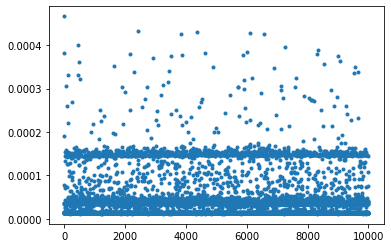

In [23]:
plt.figure()
plt.plot(latencies[1] , '.')

In [5]:
pcf = os.path.join(EXP, 'moongen', 'moongen.pcap')
pcap=dpkt.pcap.Reader(open(pcf, 'rb'))

In [7]:
for i, (ts, pkt) in enumerate(pcap):
    print(pkt)
    if i > 10:
        break

b'\x00\x04`P\xdb\xea\x00\x00\x00\x00\x00\x02\x124\x00\x00\x08\x00\x04\x10E\x00\x01\x11\x08\x04\x00\x00\x11=\x93\x9c\x01\x01\x01\x01\x01\x01\x01\x01\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11'
b'\x00\x04`R\x07\xe5\x00\x00\x00\x00\x00\x02\x124\x00\x01\x08\x00\x04\x10E\x00\x01\x11\x1c\x17\x00\x00"=m\x87\x02\x02\x02\x02\x02\x02\x02\x02"""""""""""""""""""""""""""""""""""""""""""""""""""'
b'\x00\x04`SUI\x00\x00\x00\x00\x00\x02\x124\x00\x02\x08\x00\x04\x10E\x00\x01\x110*\x00\x003=Gr\x03\x03\x03\x03\x03\x03\x03\x03333333333333333333333333333333333333333333333333333'
b'\x00\x04`T\xa2W\x00\x00\x00\x00\x00\x02\x124\x00\x03\x08\x00\x04\x10E\x00\x01\x11\xb4=\x00\x00D=\xb1\\\x04\x04\x04\x04\x04\x04\x04\x04DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD'
b'\x00\x04`U\xef\x8d\x00\x00\x00\x00\x00\x02\x124\x00\x04\x08\x00\x04\x10E\x00\x01\x1

<IPython.core.display.Javascript object>


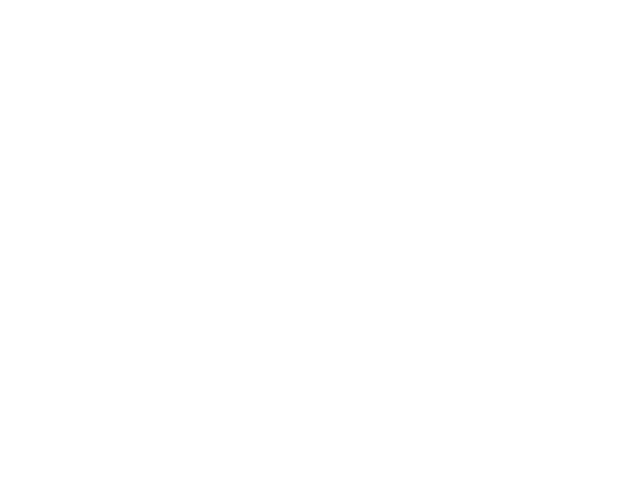

TypeError: can't multiply sequence by non-int of type 'float'

In [25]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
x = plt.hist(latencies * 1e6, 100)
plt.xlabel("Latencies (µS)")
plt.ylabel("N Pkts")
plt.yscale('log')

<IPython.core.display.Javascript object>


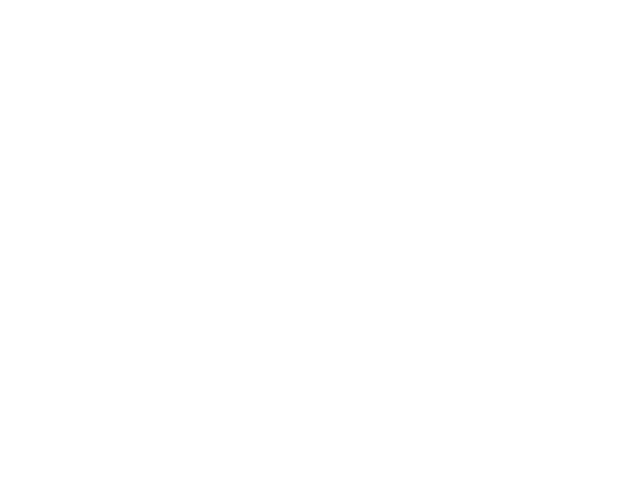

TypeError: can't multiply sequence by non-int of type 'float'

In [15]:
plt.figure()
plt.plot(latencies * 1e6,'.')